# Finetuning CNNs on medical image data

The objective of this homework is to use deep learning to recognize tumors in tissue image. We will use the [PCAM](https://github.com/basveeling/pcam) dataset consisting of "327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections".

**Note:** This homework will require intensive computations. It is thus preferable to use GPUs, for example with Google Colab (free access to GPUs).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
import keras
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

torch.cuda.get_device_name(0)

Using gpu: True 


'NVIDIA GeForce RTX 2060 with Max-Q Design'

## Data preprocessing

First, download the PCAM dataset using torchvision (see [documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.PCAM.html#torchvision.datasets.PCAM)). To keep computation times low, we will use the validation set (parameter `split='val'`) as train set (variable name `data_train`), and the test set (parameter `split='test'`) as test (variable name `data_test`). Plot the first 5 images of the train set corresponding to a tumor and the 5 first corresponding to healthy tissue. Can you see a difference?

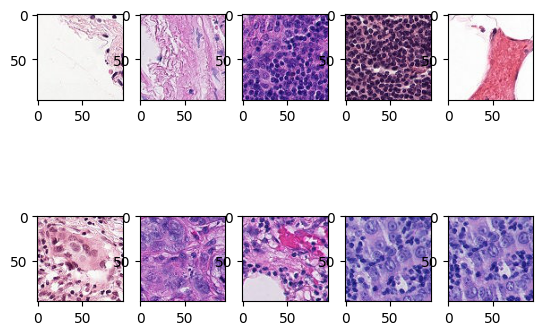

In [3]:
from dl_scaman_checker import HW01
data_train=HW01.PCAM(root='data', split='val', download=False)
data_test=HW01.PCAM(root='data', split='test', download=False)


f, axarr = plt.subplots(2,5)

i=0
c=0
while c < 5:
    if data_test[i][1]==0:
        axarr[0, c].imshow(data_test[i][0])
        c+=1
    i+=1

i=0
c=0
while c < 5:
    if data_test[i][1]==1:
        axarr[1, c].imshow(data_test[i][0])
        c+=1
    i+=1


Upper pictures are health, whereas the lower are unhealty. It is ficcicult to see the difference.

Use `data_train.transform` and `data_test.transform` (see the [documentation](https://pytorch.org/vision/0.9/transforms.html)) to turn the images into tensors (of shape (3,96,96)) and normalize them using `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`, and verify that your data has the correct shape. How many elements are in your train and test sets?

In [4]:
transform1=transforms.Compose([
    transforms.ToTensor(), 
    transforms.CenterCrop((96, 96)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))    
    ])

transform2=transforms.Compose([
    transforms.ToTensor(), 
    transforms.CenterCrop((96, 96)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    transforms.Lambda(lambda x: torch.flatten(x))
    ])

data_train=HW01.PCAM(root='data', split='val', download=False, transform=transform1)
data_test=HW01.PCAM(root='data', split='test', download=False, transform=transform1)



In [46]:
print('number of train entries:', len(data_train))
print('number of test entries:', len(data_test))
print('Shape of data entries:', data_test[0][0].size())

n_train=len(data_train)
n_test=len(data_test)


number of train entries: 32768
number of test entries: 32768
Shape of data entries: torch.Size([27648])


Now create a train and a test dataloader with a batch size of 64, and a random permutation for the train dataloader (with `shuffle=True`). How many mini-batches do you have?

In [36]:
batch_size=64
data_train=HW01.PCAM(root='data', split='val', download=False, transform=transform2)
data_test=HW01.PCAM(root='data', split='test', download=False, transform=transform2)

dataloader_train=DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_test=DataLoader(data_test, batch_size=batch_size, shuffle=True)

criterion=nn.CrossEntropyLoss()

#I have 32768/64=512 batches

## Training and testing loop

Write a function `train_model(model, dataloader, epochs)` that performs `epochs` training epochs using the Adam optimizer (with learning rate $10^{-3}$) on the cross entropy loss (using `nn.CrossEntropyLoss()`) for the model and data provided as input. **Note:** Remember to set the model to training mode using `model.train()`, and put the model and tensors on the correct device (CPU or GPU) by using `x.to(device)`. Plot the loss and accuracy of the model over the train set at each epoch.

In [44]:
   

def train_model(model, dataloader, returnVal=False, flatten=False):
    model.to(device)
    model.train()
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
    running_loss, running_acc = 0., 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        if flatten is True:
            inputs=torch.flatten(inputs, start_dim=1)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item()
        running_acc += torch.sum(preds == targets)

    print(f"[Training] Loss: {running_loss/n_train} Acc: {100 * running_acc/n_train:.2f}%")
    if returnVal is True:
        return running_loss/n_train, 100 * running_acc/n_train



Now write a function `test_model(model,dataloader)` that plots the loss and accuracy of the model on the whole dataset.

In [49]:

def test_model(model, dataloader, returnVal=False, flatten=False):
    model.to(device)
    model.eval()
    running_loss, running_acc = 0., 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            if flatten is True:
                inputs=torch.flatten(inputs, start_dim=1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item()
            running_acc += torch.sum(preds == targets)
            
    print(f"[TEST] Loss: {running_loss/n_test} Acc: {100 * running_acc/n_test:.2f}%")
    if returnVal is True:
        return running_loss/n_test, 100 * running_acc/n_test
    
def train_and_test_model(model, dataloader_train, dataloader_test, epochs, flatten=False):
    training_acc_list=[]
    training_loss_list=[]
    testing_acc_list=[]
    testing_loss_list=[]
    iteration=[]

    for it in range(1, epochs+1):
        iteration.append(it)
        training_loss, training_acc=train_model(model, dataloader_train, returnVal=True, flatten=flatten)
        testing_loss, testing_acc=test_model(model, dataloader_test, returnVal=True, flatten=flatten)
        training_acc_list.append(training_acc.cpu())
        testing_acc_list.append(testing_acc.cpu())
        training_loss_list.append(training_loss)
        testing_loss_list.append(testing_loss)

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(iteration, training_acc_list, color=color, linestyle='dashed', label="Training accuracy")
    ax1.plot(iteration, testing_acc_list, color=color, label="Testing accuracy")
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper right')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(iteration, training_loss_list, color=color, label='Train Loss', linestyle='dashed')
    ax2.plot(iteration, testing_loss_list, color=color, label="Testing Loss")
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper Left')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


## Training a linear model

We now test a baseline model on our classification task: a simple linear model. Create a model using `nn.Sequential` that takes images, flatten them into vectors, and then compute a linear model out of it. The output should be 2-dimensional (to match our 2 classes). Then, train it for 2 epochs and test it on the test dataset.

MLP(
  (layers): Sequential(
    (0): Linear(in_features=27648, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1000, out_features=500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=2, bias=True)
  )
)
[Training] Loss: 0.01235114475912269 Acc: 67.74%
[TEST] Loss: 0.011275313618170912 Acc: 66.61%
[Training] Loss: 0.009360232492326759 Acc: 68.18%
[TEST] Loss: 0.01602325979001762 Acc: 66.29%


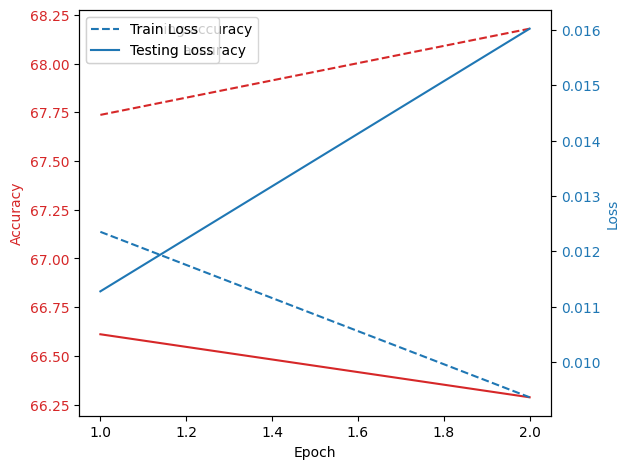

CPU times: total: 3min 40s
Wall time: 5min 6s


: 

In [58]:
%%time
class MLP(nn.Module):

    training_acc=[]

    def __init__(self, width, depth, input_width=27648):
        super().__init__()
        layers = []
        if depth == 1:
            layers.append(nn.Linear(input_width, 2))
        else:
            layers += [nn.Linear(input_width, width, bias=True), nn.ReLU(), nn.Dropout(p=0.5, inplace=False)]
            for divisor in range(depth-1):
                layers += [nn.Linear(int(width/(2**divisor)), int(width/(2**(divisor+1))), bias=True), nn.ReLU(), nn.Dropout(p=0.5, inplace=False)]
            layers += [nn.Linear(int(width/(2**(divisor+1))), 2, bias=True)]
            
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

model=MLP(width=1000, depth=2)
print(model)
epochs=2

train_and_test_model(model, dataloader_train, dataloader_test, epochs)
del model

## Fine-tuning a CNN model

We are now going to fine-tune a VGG model trained on [ImageNet](http://www.image-net.org/) (1.2M training images). The torchvision module comes with a zoo of pretrained popular CNN architectures. When called the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`. For next calls, the model will be directly read from there.

First, load the VGG model using `models.vgg16(weights='DEFAULT')` and print it to see its architecture.

In [10]:
model_vgg=models.vgg16(weights='DEFAULT')
batch_size=256
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Note that the model is divided into two part: a **feature** section mainly made of convolutions and pooling layers, and a **classifier** part made of an MLP. We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

The idea of fine-tuning is that the features computed by VGG for Imagenet may be also good for other applications (e.g. for medical images). Replace the last layer of the `model_vgg.classifier` by a new linear layer that outputs 2 values (one for each class), and **freeze** all the other parameters of the VGG model by using `parameter.requires_grad=False` on all the parameters of the model except for the last layer.

In [11]:
def get_vgg():
    model_vgg=models.vgg16(weights='DEFAULT')
    model_vgg.classifier[-1]=nn.Linear(4096, 2)
    param_list=list(model_vgg.parameters())
    for param in param_list[:-1]:
        param.requires_grad=False

    return model_vgg

get_vgg()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Now fine-tune the model by performing 2 epochs of training.

In [12]:
%%time
data_train=HW01.PCAM(root='data', split='val', download=False, transform=transform1)
data_test=HW01.PCAM(root='data', split='test', download=False, transform=transform1)
dataloader_train=DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_test=DataLoader(data_test, batch_size=batch_size, shuffle=True)



CPU times: total: 0 ns
Wall time: 4.08 ms


In [ ]:
for epochs in range(2):
    train_model(model_vgg, dataloader_train)

test_model(model_vgg, dataloader_test)

## Speeding-up training by precomputing features

We are wasting a lot of time computing over and over the same quantities. Indeed, the first part of the VGG model (called `features` and made of convolutional layers) is frozen and never updated. Hence, we can precompute for each image in the dataset, the output of these convolutional layers as these outputs will always be the same during your training process.

Write a function `precompute_model(model, dataloader)` that takes a model and a dataloader as input, and returns a dataset containing the outputs of the model as input using `torch.utils.data.TensorData`.

In [17]:
def precompute_model(model, dataloader):
    model.eval()
    model.to(device)

    # Lists to store input and output tensors
    target_list = []
    output_list = []

    with torch.no_grad():
        for inputs, target in dataloader:
            inputs = inputs.to(device)

            outputs = model(inputs)

            target_list.append(target)
            output_list.append(outputs.cpu())

    target_dataset = torch.cat(target_list, dim=0)
    output_dataset = torch.cat(output_list, dim=0)

    precomputed_dataset = torch.utils.data.TensorDataset(output_dataset, target_dataset)
    
    #returning dataloader with dataset
    return precomputed_dataset


dataset_preprocess=precompute_model(model_vgg.features, dataloader_train)
dataset_preprocess_test=precompute_model(model_vgg.features, dataloader_test)


Use `precompute_model` to create a DataLoader for the train and test dataset with precomputed VGG features.

[Training] Loss: 0.002534209170335089 Acc: 87.64%
[TEST] Loss: 0.026078824279466062 Acc: 73.84%
[Training] Loss: 0.0024994015593620134 Acc: 88.10%
[TEST] Loss: 0.041632048780229525 Acc: 72.21%
[Training] Loss: 0.002514673263704026 Acc: 87.88%
[TEST] Loss: 0.0474560978327645 Acc: 74.86%
[Training] Loss: 0.0024714969226806716 Acc: 88.38%
[TEST] Loss: 0.03101384374895133 Acc: 73.74%
[Training] Loss: 0.002490954581389815 Acc: 88.41%
[TEST] Loss: 0.03755364020889829 Acc: 75.01%


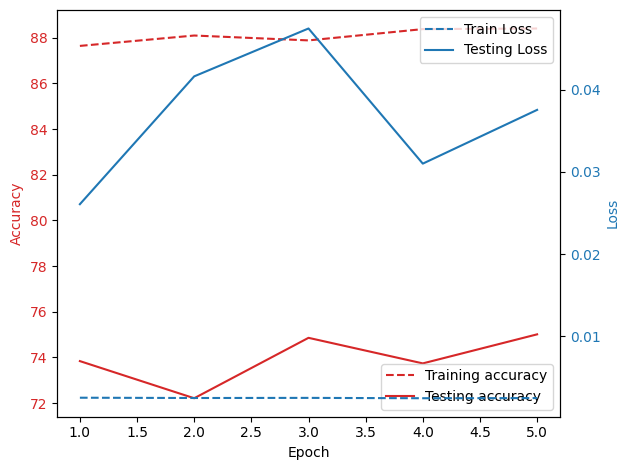

CPU times: total: 1min 4s
Wall time: 1min 34s


In [57]:
%%time

dataloader_preprocess = torch.utils.data.DataLoader(dataset_preprocess, batch_size=128, shuffle=True)
dataloader_preprocess_test = torch.utils.data.DataLoader(dataset_preprocess_test, batch_size=128, shuffle=True)

#removes feature-layers from model
model_vgg.features = nn.Sequential(*list(model_vgg.features.children())[:-100])

train_and_test_model(model_vgg, dataloader_preprocess, dataloader_preprocess_test, 5)


Finally, train a linear model on the our new precomputed features for 50 epochs. Is the model better?

MLP2(
  (layers): Sequential(
    (0): Linear(in_features=4608, out_features=3000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=3000, out_features=1500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1500, out_features=750, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=750, out_features=375, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=375, out_features=187, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=187, out_features=2, bias=True)
  )
)
[Training] Loss: 0.0027979288993265072 Acc: 83.62%
[TEST] Loss: 0.004681550350142061 Acc: 76.54%
[Training] Loss: 0.002019734761233849 Acc: 89.26%
[TEST] Loss: 0.00714981676901516 Acc: 72.59%
[Training] Loss: 0.0016812580470286775 Acc: 91.39%
[TEST] Loss: 0.007138281246625411 Acc: 75.35%
[Training] Loss: 0.

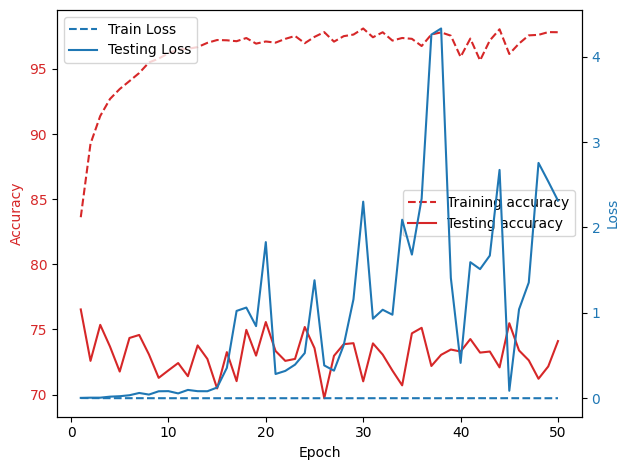

CPU times: total: 59 s
Wall time: 3min 56s


In [56]:
%%time

class MLP2(nn.Module):


    def __init__(self, width, depth, input_width=4608, dropout=0.5):
        super().__init__()
        layers = []
        if depth == 1:
            layers.append(nn.Linear(input_width, 2))
        else:
            layers += [nn.Linear(input_width, width, bias=True), nn.ReLU(), nn.Dropout(p=dropout, inplace=False)]
            for divisor in range(depth-1):
                layers += [nn.Linear(int(width/(2**divisor)), int(width/(2**(divisor+1))), bias=True), nn.ReLU(), nn.Dropout(p=dropout, inplace=False)]
            layers += [nn.Linear(int(width/(2**(divisor+1))), 2, bias=True)]
            
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)



model=MLP2(3000, 5, input_width=4608, dropout=0.2)
epochs=50
print(model)

train_and_test_model(model, dataloader_preprocess, dataloader_preprocess_test, epochs, flatten=True)


CONCLUSION: Since we didnt run more than 2 epochs, it is difficult to say with certainty. But most  importantly since we have cut the inputs by one sixths, the training speed is approximatley 36 times faster. 

One would assume that a CNN is suitable since it reduces the risk of a cancer-feature being in a particular spot in the picuture induces some sort of bias.

We can see that with 5 layers and a dropout of 0.2, the training accuracy stabilizes at approximatley 97% whereas the testing remains around 73. The testing accuracy is comparablet to the VGG-model but a lot better that the unprocessed nural network.
For the unprocessed nural network, with almost 28000 entries, there is a reisk that there is "too much to learn" for the model. There are almost as many dimensions as data-entries. This can make the model over-fit if trained for a long time and adding dropout for exapmple can the risk reducing the complexity that is needed for all dimensions.

We can also see that the loss for the testing skyrockets, even if the accutacy stays pretty stationary.
